# Time Series Analysis I

## Categories of Bonds

| $\text{Type}$     | $\text{Maturity}$                        |
| ----------------- | ---------------------------------------- |
| $\text{Bill (b)}$ | $1\text{m} \leq \text{T} \lt 1\text{Y}$  |
| $\text{Note (N)}$ | $1\text{Y} \leq \text{T} \lt 10\text{Y}$ |
| $\text{Bond (B)}$ | $\quad\quad\ \text{T} \geq 10\text{Y}$   |

## What is a Constant Maturity Treasury?

According to [Investopedia](https://www.investopedia.com/terms/c/constantmaturity.asp), Constant Maturity is an adjustment for equivalent maturity, used by the Federal Reserve Board to compute an index based on the average yield of various Treasury securities, maturing at different periods.

One would use constant maturity yields as reference for pricing all kinds of depts or fixed income securities, fixed income securities being by far the largest type of security in U.S. securities markets.

## Nominal Yield Curve Rates vs. Real Yield Curve Rates

According to the Board of Governors of the Federal Reserve System, a [nominal Treasury security](https://www.federalreserve.gov/data/nominal-yield-curve.htm) is an issuance that specifies principal and interest as fixed dollar amounts to the holder. Since Treasury securities are backed by the full faith and credit of the U.S. government, the returns investors can earn on them are often used as a “risk-free” benchmark in finance research and investment practice. These securities are a promise to repay the principal (with interest if a note or a bond) to the holder (can be a public or private entity). Therefore, the real yield curve rate would be adjusted for inflation of interest rates, thereby used to determine risk-neutral cashflow.

The **nominal yield curve rate** adds a market average of the expected inflation risk premium to the real. Investors must be compensated for the risk of inflation in bond yields. The real yield determines the cashflow an investor in secondary markets can obtain by purchasing $\text{TIPS}$, which are Inflation Protected Securities offered by the U.S. Treasury department and other stakeholders that offer similar inflation protection to investors.

## Statement of Purpose

The purpose of this time series analysis is to build from my US Treasury Securities Exploratory Analysis, using a **data-driven approach** to modeling. I will be determining yield stability, choosing the best data-driven ARIMA model for the different categories of CMTs and draw conclusions about any experimental forecast that can be built after constructing models with nonstationarity removed. The nonstationarity will be analyzed later using residual plots and volatility models in `Treas TS Analysis II`.

`] add Turing@0.13.0`

## Loading Yield Curve Rate Inflation `CSV` File

In [1]:
using CSV, DataFrames

tnf = CSV.read("tnf.csv", DataFrame)

,x5,x7,x10,x20,x30
,Float64,Float64,Float64,Float64,Float64
1,1.49239,1.58039,1.69647,1.75519,1.78426
2,1.4913,1.562,1.6829,1.74316,1.7758
3,1.57973,1.64966,1.75581,1.78013,1.80855
4,1.61299,1.68424,1.77541,1.80426,1.81202
5,1.66448,1.71853,1.81737,1.8489,1.85057
6,1.6773,1.74478,1.82976,1.84744,1.8689
7,1.65266,1.71964,1.81201,1.8382,1.85974
8,1.66312,1.73871,1.82968,1.85278,1.86454
9,1.64498,1.7151,1.80905,1.84094,1.8623


I have the dataset to be analyzed.

## Time Series Analysis

The `tnf` dataset contains the inflation rates for CMT maturities $T \in [5, 7, 10, 20, 30]$ years. Recall that this inflation analysis is only for columns $10$ to $14$ of the original datasets, because columns $10$ to $14$ were the only nonempty columns in the `R_CMT` dataset.

This analysis continues with a data-driven approach to modelling. Linear methods can be used to solve certain nonlinear problems, but since they are nonlinear, a top-down approach, where one chooses a known statistical PDF kernel function, does not work on nonlinear stochastic processes.

### Building (Test) and Training Sets & Plotting Results as Done Earlier

As metnioned in my `Treas Exploratory Analysis`, there seems to be correlation across maturities in the Treasury yield curve inflation. Here is a rework of these results.

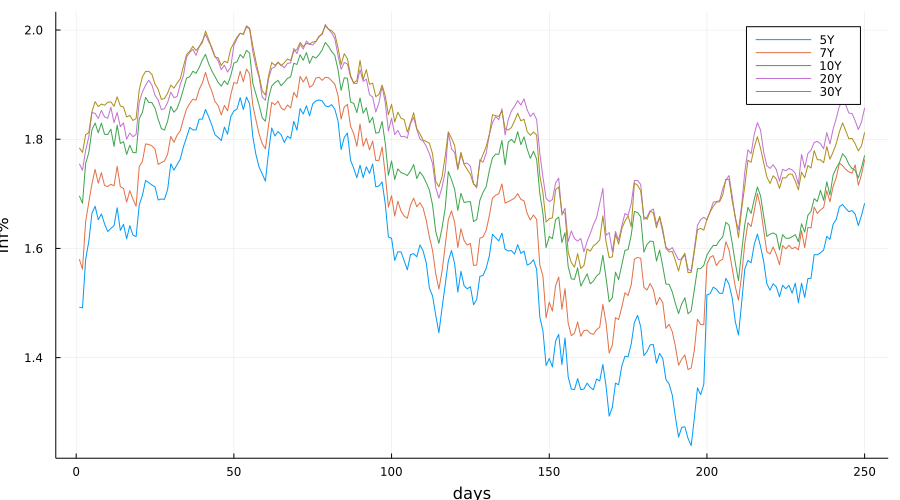

In [2]:
include("helpers.jl"); using Plots

s = tnf
lb = ["5Y", "7Y", "10Y", "20Y", "30Y"]; s_train, s_test, p = h1(s, lb, 1); p

I will be analysing correlation across maturities in `Treas TS Analysis II`.

### Differencing Time Series

Earlier, I had taken first-differences without first taking the **logarithm** of the yield curve rates, but if I want to use the Akiake Information Criterion, this would not work, because the $\text{AIC}$ applies a log-likelihood function to the model.

I am taking **first-differences of the log-transformed** time series data, choosing a lag of one (1) for marginal differences. This will not tell me whether or not the logarithm of the data is normally distributed but I would know whether or not the values themselves are normally distributed, using a **J-B Test**.

Before I log-transform the inflation series, I need to test for negative values, which I will need to do, given that logarithms do not work for negative values.

In [3]:
h5(s_train)

5-element Array{Int64,1}:
 0
 0
 0
 0
 0

Not finding any negative value in the inflation rates, I now take the first-differences of log-transformed inflation rates, and plot to see what it looks like.

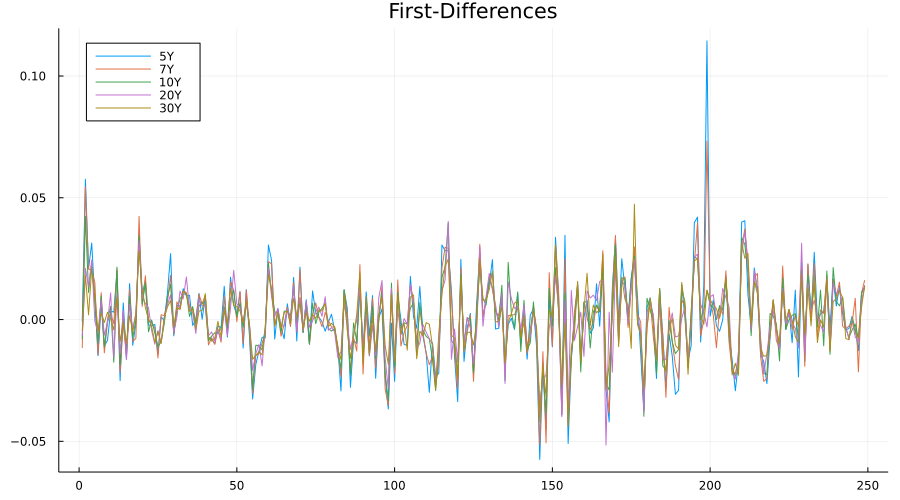

In [4]:
s_diff = diff(log.(Matrix(s_train)), dims = 1); lb = ["5Y", "7Y", "10Y", "20Y", "30Y"]
h4(s_diff, "First-Differences", 1, 5, lb)

It seems to be more "stationary", so there is at least one order of differencing in the series.

### Running Augmented Dickey-Fuller (ADF) Test to $\text{Confirm}^*$ Stationarity

**Some clarifications**: the following models are on log-transformed first-differences, not the original data. The first-differences may be, e.g., a white noise series, and the original data could be a series based on a log-normal or Cauchy variable, which is why a data-driven approach to modeling is more precise, to let the data speak for itself, after removing non-stationarity and thereby, determining the differencing order of the series.

Here, I am testing for unit root, thereby confirming$^*$ that the differenced time series is either stationary or trend-stationary. If there is no unit root ($H_0$), the time series would be a random walk

$$
    H_0: \hat{Y_t} = \mu + \beta_t + \phi Y_{t - 1} + \epsilon_t
$$

for $\phi \neq 0$, where the constant term, $\mu$ (not always zero), is depicted for completion of the formula, as well as the error term, $\epsilon_t$.

$^*$under the $5\%$ confidence level

I then test for $H_0$, that there is no unit root, against $H_a$, that there is a unit-root present and the time series is neither stationary nor trend stationary (indicating that there is no regression to the mean). There are many nonstationary models, some involving an $\text{AR}$ term, others an $\text{MA}$ term and some a combination of both. Some models are volatility models, like $\text{GARCH}$; I will be modeling volatility in `Treas TS Analysis II`.

Also, for completion of the formula, $\beta_t$ is introduced, but with no linear trend in the data, by $\textit{modus ponendo ponens}$, I have that

$$
    \beta_t = 0\ \forall t \rightarrow H_0 : \hat{Y_t} = \mu + \phi Y_{t-1} + \epsilon_t \\
    \beta_t = 0\ \forall t \\
    \therefore H_0 : \hat{Y_t} = \mu + \phi Y_{t-1} + \epsilon_t
$$

The constant term, $\mu$, can be replaced with $\mu = 0$, further simplifying the model to $H_0 : \hat{Y_t} = \phi Y_{t-1} + \epsilon_t$, but what if $\mu \neq 0$? I will be investigating the constant term in `Treas TS Analysis III`.

If the $\text{ADF}$ test on first-differences results in stationarity, I would succeed. Otherwise, I would need to difference again, taking another $\text{ADF}$ test, and repeating for as along as there is nonstationarity left in the model. The end result would be that I can model a time series for $\text{ARIMA}(p, d, q)$, as in the precedure illustrated below.

$$
    \text{let}\ W_t = Y_t - Y_{t - 1} \\~\\
    \therefore \forall t:
    W_t = \mu + \overbrace{\phi_1 W_{t -1} + \phi_2 W_{t - 2} + \cdots + \phi_p W_{t - p}}^{\text{lagged W values}} + \epsilon_t - \underbrace{\theta_1 \epsilon_{t - 1} - \theta_2 \epsilon_{t - 2} - \cdots - \theta_q \epsilon_{t - q}}_{\text{lagged error terms}} \quad \forall \phi \in (-1, 1), \quad \forall \theta \in [-1, 1] \quad \backslash 0
$$

where $\epsilon_t \sim \mathcal{N}(\mu_\epsilon, \sigma^2_\epsilon)$ is an error term, and $\theta \in [-1, 1]$, for invertibility of the lagged errors. Taking a lag of $k = \lfloor(n - 1)^{(1 \ / \ m)}\rfloor$, where $m = 3$ and $n$ is the number of time periods for the univariate regressor, I then have

In [5]:
using HypothesisTests

Y = s_diff
m = 3
[ADFTest(Y[:, C], Symbol("constant"), trunc(Int, (length(Y)-1)^(1/m))) for C in 1:5]

5-element Array{ADFTest,1}:
 Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.962209

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-4

Details:
    sample size in regression:          238
    number of lags:                     10
    ADF statistic:                      -4.72816
    Critical values at 1%, 5%, and 10%: [-3.45689 -2.87322 -2.57299]

 Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -1.06036

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-4

Details:
    sample size in regression:          238
    number of lag

This results in acceptance of the $H_0$ hypothesis for all tests, which means that there is no unit root for the first-differences of the inflation rates. This means that there is stationarity in the data, since there is no $\beta$ defining a linear trend in the series (i.e., not a trend-stationary time series), which means that the differencing order $d = 1$. I will now evaluate how "normal" the time series are distributed, at the $5\%$ confidence level ($\alpha = 5\%$), using the Jarque-Bera test.

### Running Jarque-Bera Lagrange Multiplier Test to Evaluate Normality and Further Notes on Log-Transformed First-Differences

When I first tackled this section, I thought I was unable to perform log-normal transformation on the $7$ and $10$ year real CMT rates, since five (5) of the real yield curve rate entries are $< 0$ for the $7$ year and nine (9) of the entries are $< 0$ for the $10$ year, but then I looked at it again, and I was taking logarithms for the original data (nominal and real CMT values) and not the inflation rates themselves.

In addition, I must keep in mind that there is a difference between a normal and log-normal series distribution. A series could be normally distributed but not log-normally distributed. A series that is log-normally distributed is normally distributed **in its logarithm**.

If I want to find out if a series that is normally distributed **in its random variable** (each stochastic process involves a random variable) is also normally distributed **in its logarithm**, I would need to perform a **J-B test** on the log-variable in question (or series determined by such log-variable), prior to differencing the logirthm of inflation rates in the yield curve.

$\therefore$

Following the equation

$\log{(B)} - \log{(A)} = \log{\left(\frac{B}{A}\right)}$

NOT

$\log({B}) - \log({A}) \neq \log{(B - A)} = \log{(C)}, \quad \text{where}\ C = B - A$

I would first need to make sure that the logarithm of each inflation rate is nonnegative and then take first-differences (finding negative nominal or real values has nothing to do with the process at hand, provided that the inflation rates are nonnegative), which is why

In [6]:
h5(tnf)

5-element Array{Int64,1}:
 0
 0
 0
 0
 0

which means that none of the inflation rates are negative. Furthermore,

In [7]:
Y = s_diff
[JarqueBeraTest(Y[:, C]) for C in 1:5]

5-element Array{JarqueBeraTest,1}:
 Jarque-Bera normality test
--------------------------
Population details:
    parameter of interest:   skewness and kurtosis
    value under h_0:         "0 and 3"
    point estimate:          "0.7809526905326842 and 8.206064961211712"

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-66

Details:
    number of observations:         249
    JB statistic:                   306.505

 Jarque-Bera normality test
--------------------------
Population details:
    parameter of interest:   skewness and kurtosis
    value under h_0:         "0 and 3"
    point estimate:          "0.18512014963204018 and 4.496290813804878"

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-5

Details:
    number of observations:         249
    JB statistic:                   24.6506

 Jarque-Bera normality test
--------------------------
Population details:
    parameter of interest:  

**Note:** As of $18$ Jan $2022$, the above error is no longer relevant, since I moved all the analysis on the original `tux` and `tuy` dataframes to `Exploratory Analysis`.

$\therefore$

Log-transformed first-differences for Year (10) bond CMT inflation are normally distributed. Rejecting at the $5\%$ confidence level, the $5$, $7$, $20$ and $30$ year inflation series have skewness and excess kurtosis greater than zero (0) (and no unit root at the $5\%$ level for $2019$ as per the ADF test results).

I can confortably reject $H_0$ for all inflation rates, except the $10$Y bond, establishing that these series are not normal in their logarithm or log-normal for any predictive model that can be built based on these test results, with $95\%$ confidence. The $10$Y bond is log-normal for fiscal year $2019$, however.

Regardless, it is best practice to use the first-differences of log transformations for Treasury securities with maturities $C \in \{5, 7, 10, 20, 30\}$ years, due to the $\text{AIC}$ condition mentioned earlier.

## Plotting ACF and PACF $+$ Akiake Information Criterion (AIC) Statespace Modeling

$
    W_t = \mu + \overbrace{\phi_1 W_{t -1} + \phi_2 W_{t - 2} + \cdots + \phi_p W_{t - p}}^{\text{lagged W values}} + \epsilon_t - \underbrace{\theta_1 \epsilon_{t - 1} - \theta_2 \epsilon_{t - 2} - \cdots - \theta_q \epsilon_{t - q}}_{\text{lagged error terms}} \quad \forall \phi \in (-1, 1) \quad \forall \theta \in [-1, 1] \quad \backslash 0
$

### ACF & PACF: Selecting the Moving Average (MA) and Autoregressive (AR) Terms

I will now determine the ACF and PACF for the above differenced time series. With a **differencing parameter $d = 1$**, the other two parameters in an $\text{ARIMA}(p, 1, q)$ model, the **$p$ (lagged Y values)** and the **$q$ (lagged errors)** in the inflation data will be determined subsequently. Two functions come to mind: the autocorrelation function (ACF) and its partial counterpart, the PACF.

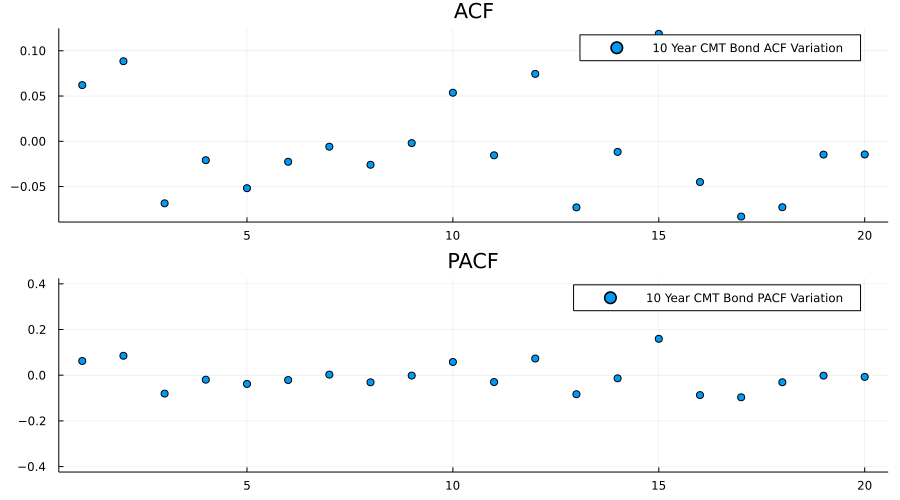

In [8]:
using StatsBase

Y = s_diff[:, 3]
total_lags = 20

s1 = scatter(collect(1:total_lags), autocor(Y, collect(1:total_lags)), title = "ACF", label = "10 Year CMT Bond ACF Variation")
s2 = scatter(collect(1:total_lags), pacf(Y, collect(1:total_lags)), title = "PACF", ylim = [-0.4,0.4], label = "10 Year CMT Bond PACF Variation");

plot(s1, s2, layout = (2, 1), size = (900, 500))

I honestly don't know how to interpret these charts too well. In the `R` programming language it is a lot easier, so I will try

$\forall$ bond CMT inflation series

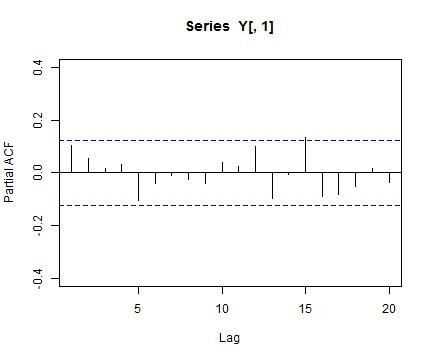

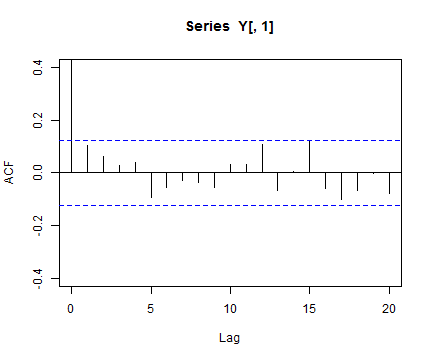

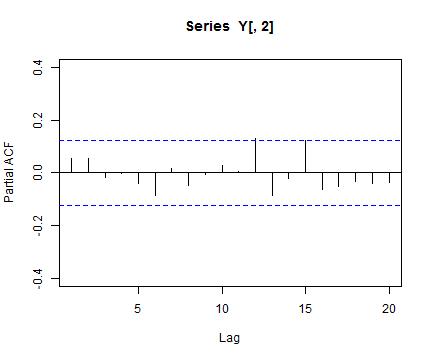

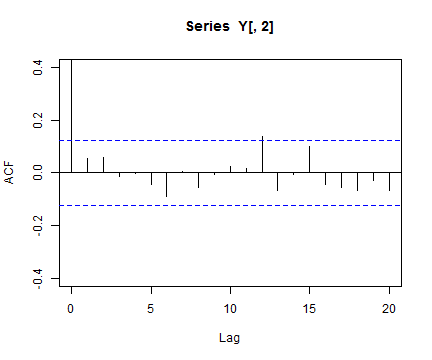

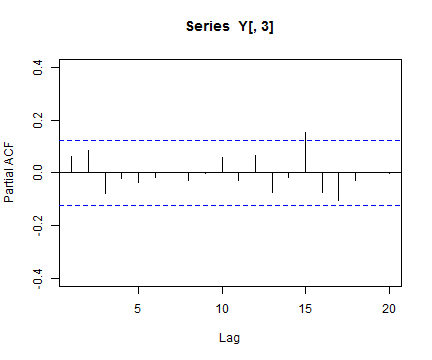

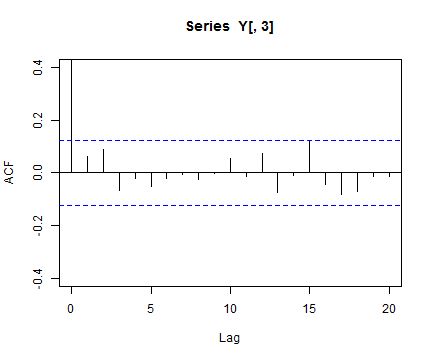

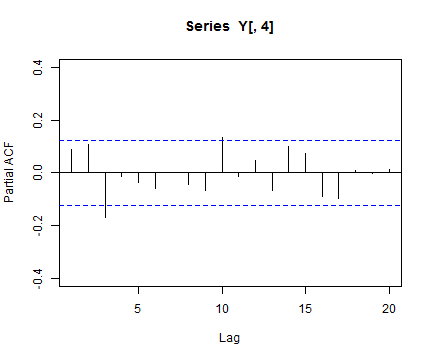

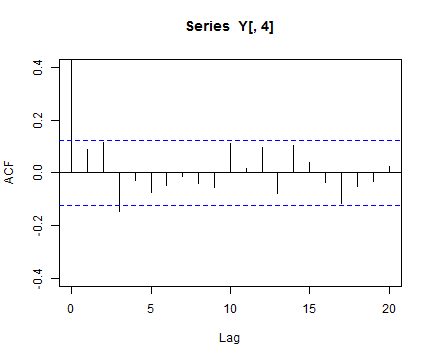

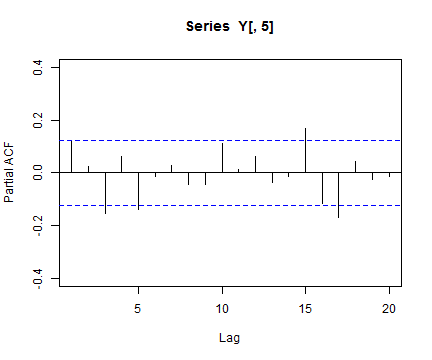

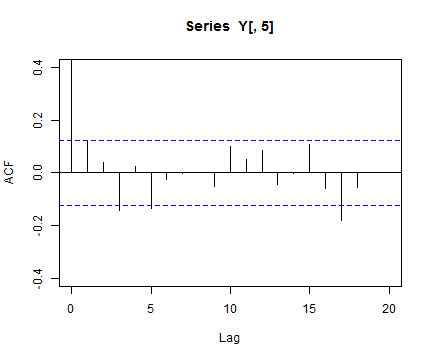

┌ Warning: RCall.jl: Loading required package: tseries
│ Registered S3 method overwritten by 'quantmod':
│   method            from
│   as.zoo.data.frame zoo 
│ 
│     'tseries' version: 0.10-48
│ 
│     'tseries' is a package for time series analysis and computational
│     finance.
│ 
│     See 'library(help="tseries")' for details.
│ 
└ @ RCall C:\Users\Owner\.julia\packages\RCall\iMDW2\src\io.jl:160


RObject{VecSxp}

Autocorrelations of series 'Y[, 5]', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000  0.124  0.040 -0.144  0.023 -0.136 -0.025 -0.002  0.002 -0.054  0.101 
    11     12     13     14     15     16     17     18     19     20 
 0.051  0.085 -0.046 -0.004  0.106 -0.060 -0.180 -0.057  0.000  0.001 


In [9]:
using RCall

Y = s_diff
@rput Y
R"""
    options(warn=-1)

    par(mfrow=c(1, 1))
    require("tseries")

    pacf(Y[, 1], lag = 20, ylim = c(-0.4, 0.4))
    acf(Y[, 1], lag = 20, ylim = c(-0.4, 0.4))

    pacf(Y[, 2], lag = 20, ylim = c(-0.4, 0.4))
    acf(Y[, 2], lag = 20, ylim = c(-0.4, 0.4))

    pacf(Y[, 3], lag = 20, ylim = c(-0.4, 0.4))
    acf(Y[, 3], lag = 20, ylim = c(-0.4, 0.4))

    pacf(Y[, 4], lag = 20, ylim = c(-0.4, 0.4))
    acf(Y[, 4], lag = 20, ylim = c(-0.4, 0.4))

    pacf(Y[, 5], lag = 20, ylim = c(-0.4, 0.4))
    acf(Y[, 5], lag = 20, ylim = c(-0.4, 0.4))
"""

The auto-regressive series is independently distributed, but I have to gain more insight using the Akiake Information Criterion and the log-likelihood function.

### The Akiake Information Criterion

The Akiake Information Criterion says that

$$
    \text{AIC} = -\frac{2}{T}\ln(\text{likelihood)} + \frac{2}{T}\times \text{(number of parameters)}
$$

where $T$ is the sample size. I would first need to find what the log-likelihood function has to say about the data.

### The Log-Likelihood Function

For the AIC, the log-likelihood is evaluated at the maximum likelihood estimates. The following is incorrect, because later I realize that I am working with an $\text{ARIMA}$ model, and the following is an $\text{AR}$ process I copied from Dr. Ruey Tsay's Financial Time Series textbook (p. 45). I need to model both $\text{AR}$ and $\text{MA}$.

**Maturity $T = 5$Y**

In [10]:
Y = s_diff[:, 1]
@rput Y
R"""
    ord=ar(Y, method = "mle")
    ord$aic
"""

RObject{RealSxp}
         0          1          2          3          4          5          6 
 0.6833669  0.0000000  1.3051038  3.2475167  5.0225820  4.0964049  5.6248133 
         7          8          9         10         11         12 
 7.5885415  9.3957141 10.9688285 12.5605474 14.3780938 13.6252512 


The minimum occurs at $p = 1$. Therefore, $\text{AR}(1)$ is preferred by the criterion, and

In [11]:
R"ord$order"

RObject{IntSxp}
[1] 1


$\therefore$ an $\text{AR}(1)$ model "seems" to best fit the data.

**Maturity $T = 7$Y**

In [12]:
Y = s_diff[:, 2]
@rput Y
R"""
    ord=ar(Y, method = "mle")
    ord$aic
"""

RObject{RealSxp}
        0         1         2         3         4         5         6         7 
 0.000000  1.218020  2.500159  4.400448  6.399119  7.955500  7.853835  9.782546 
        8         9        10        11        12 
11.151428 13.139979 14.910193 16.905370 14.300259 


The minimum occurs at $p = 0$. Therefore, $\text{AR}(0)$ is preferred by the criterion, and

In [13]:
R"ord$order"

RObject{IntSxp}
[1] 0


$\therefore$ an $\text{AR}(0)$ model "seems" to best fits the data.

**Maturity $T = 10$Y**

In [14]:
Y = s_diff[:, 3]
@rput Y
R"""
    ord=ar(Y, method = "mle")
    ord$aic
"""

RObject{RealSxp}
        0         1         2         3         4         5         6         7 
 0.000000  1.038222  1.224013  1.502716  3.403161  5.056371  6.959160  8.958437 
        8         9        10        11        12 
10.746808 12.745380 13.905299 15.716963 16.476006 


The minimum occurs at $p = 0$. Therefore, $\text{AR}(0)$ is preferred by the criterion, and

In [15]:
R"ord$order"

RObject{IntSxp}
[1] 0


$\therefore$ an $\text{AR}(0)$ model "seems" to best fit the data.

**Maturity $T = 20$Y**

In [16]:
Y = s_diff[:, 4]
@rput Y
R"""
    ord=ar(Y, method = "mle")
    ord$aic
"""

RObject{RealSxp}
       0        1        2        3        4        5        6        7 
6.166773 6.247348 5.386083 0.000000 1.933997 3.634565 4.697603 6.697581 
       8        9       10       11       12 
8.198617 9.040386 6.455274 8.410069 9.905010 


The minimum occurs at $p = 3$. Therefore, $\text{AR}(3)$ is preferred by the criterion, and

In [17]:
R"ord$order"

RObject{IntSxp}
[1] 3


$\therefore$ an $\text{AR}(3)$ model "seems" to best fit the data.

**Maturity $T = 30$Y**

In [18]:
Y = s_diff[:, 5]
@rput Y
R"""
    ord=ar(Y, method = "mle")
    ord$aic
"""

RObject{RealSxp}
       0        1        2        3        4        5        6        7 
6.149448 4.255208 6.101362 2.024528 3.084253 0.000000 1.938705 3.755368 
       8        9       10       11       12 
5.227053 6.751342 5.697543 7.654748 8.706592 


The minimum occurs at $p = 5$. Therefore, $\text{AR}(5)$ is preferred by the criterion, and

In [19]:
R"ord$order"

RObject{IntSxp}
[1] 5


$\therefore$ an $\text{AR}(5)$ model "seems" to best fit the data; however, none of the above is true, because I was finding log-likelihood of the $\text{AR}$ component, alone, instead of $\text{AR}$ in tandem with $\text{MA}$.

## Constructing ARIMA Models

With the information I have, I may proceed to construct $\text{ARIMA}(p, 1, q)$ models in `Python`.

I am saving each column of `s_diff` as comma-split value (CSV) files for maturities corrensponding to $T \in [5, 7, 10, 20, 30]$ and switching to the Python kernel for executing `Python` code for a precise statspace modeling approach, but first to save the first-differences as a CSV file.

In [20]:
using CSV

CSV.write("log_diff.csv", (x5 = s_diff[:, 1], x7 = s_diff[:, 2], x10 = s_diff[:, 3], x20 = s_diff[:, 4], x30 = s_diff[:, 5]));

Switching to `Python` kernel to `list` available packages

In [1]:
pip list

Package                       VersionNote: you may need to restart the kernel to use updated packages.
----------------------------- -------------------
anyio                         2.1.0
argon2-cffi                   20.1.0
async-generator               1.10
attrs                         20.3.0
Babel                         2.9.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.1
beautifulsoup4                4.9.3
bleach                        3.3.0
brotlipy                      0.7.0
certifi                       2021.5.30
cffi                          1.14.3
chardet                       3.0.4
colorama                      0.4.4
conda                         4.10.3
conda-package-handling        1.7.2
cryptography                  3.2.1
cycler                        0.10.0
decorator                     4.4.2
defusedxml                    0.6.0
entrypoints                   0.3
htmlmin                       0.1.12
idna                          2.10
ImageHash    

and seeing that all of the packages I need are available, I may safely continue. Earlier I had to install `statsmodels` and `matplotlib` using the `Anaconda Powershell Prompt` and calling `python -m pip` to

```python
install matplotlib, statsmodels
```

Then, I import required packages

In [2]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as mt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

and define the following $\text{ARIMA}(p, d, q)$ optimizer.

In [3]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

I read the log-differenced series saved earlier in this notebook.

In [4]:
data = pd.read_csv("log_diff.csv")
data.head()

,x5,x7,x10,x20,x30
0,-0.000729,-0.011705,-0.008035,-0.006877,-0.004754
1,0.057604,0.054608,0.042412,0.020985,0.018271
2,0.020836,0.020743,0.011102,0.013467,0.001918
3,0.031421,0.020154,0.023359,0.024437,0.021054
4,0.007677,0.015162,0.006799,-0.000791,0.009855


I figured I also needed to install these for profiling:

```python
pip install ipywidgets widgetsnbextension pandas-profiling
```

Setting up the problem

In [5]:
import itertools

ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = itertools.product(ps, qs)
parameters_list = list(parameters)

I find out that I was wrong to assume that I have an $\text{AR}(3)$ model for the $20$Y CMT bond yield curve rates, because

In [6]:
order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

result_df = optimize_ARIMA(order_list, exog=data["x20"])
result_df

,"(p, d, q)",AIC
0,"(3, 1, 1)",-1434.488000
1,"(0, 1, 4)",-1434.139109
2,"(0, 1, 5)",-1432.099500
3,"(0, 1, 3)",-1431.559586
4,"(2, 1, 3)",-1431.314929
...,...,...
59,"(4, 1, 0)",-1387.749310
60,"(3, 1, 0)",-1380.501946
61,"(2, 1, 0)",-1364.575366
62,"(1, 1, 0)",-1361.503010


indicates that the Treasury bond with $20$Y maturity follows an $\text{ARIMA}(3, 1, 1)$ model, as preferred by the criterion in 2019. Likewise, for the $30$Y bonds, on average, I have

In [7]:
order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

result_df = optimize_ARIMA(order_list, exog=data["x30"])
result_df

,"(p, d, q)",AIC
0,"(2, 1, 3)",-1463.585545
1,"(2, 1, 4)",-1461.575409
2,"(3, 1, 3)",-1461.321919
3,"(4, 1, 3)",-1458.489472
4,"(2, 1, 5)",-1457.711602
...,...,...
59,"(4, 1, 0)",-1407.342349
60,"(3, 1, 0)",-1407.338336
61,"(2, 1, 0)",-1380.699896
62,"(1, 1, 0)",-1374.386679


which means that an $\text{ARIMA}(2, 1, 3)$ model is preferred by the criterion and not an $\text{AR}(5)$. It is worthwhile running similar combinatorial tests on $(p, 1, q)$ for the $5$Y, $7$Y and $10$Y notes, where

In [8]:
order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

result_df = optimize_ARIMA(order_list, exog=data["x5"])
result_df

,"(p, d, q)",AIC
0,"(1, 1, 1)",-1259.650496
1,"(0, 1, 2)",-1259.311415
2,"(0, 1, 1)",-1259.119868
3,"(2, 1, 1)",-1258.472403
4,"(0, 1, 3)",-1258.237301
...,...,...
59,"(3, 1, 0)",-1219.803859
60,"(4, 1, 0)",-1219.407192
61,"(2, 1, 0)",-1206.416871
62,"(1, 1, 0)",-1185.180097


,

In [9]:
order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

result_df = optimize_ARIMA(order_list, exog=data["x7"])
result_df

,"(p, d, q)",AIC
0,"(0, 1, 1)",-1309.330141
1,"(1, 1, 1)",-1308.165090
2,"(0, 1, 2)",-1308.069408
3,"(2, 1, 3)",-1307.596899
4,"(0, 1, 3)",-1307.030485
...,...,...
59,"(4, 1, 0)",-1265.295121
60,"(3, 1, 0)",-1261.012432
61,"(2, 1, 0)",-1248.842794
62,"(1, 1, 0)",-1230.096613


and

In [10]:
order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

result_df = optimize_ARIMA(order_list, exog=data["x10"])
result_df

,"(p, d, q)",AIC
0,"(0, 1, 1)",-1393.484502
1,"(1, 1, 1)",-1392.663386
2,"(2, 1, 1)",-1392.608311
3,"(0, 1, 2)",-1392.489536
4,"(0, 1, 3)",-1392.197782
...,...,...
59,"(4, 1, 0)",-1349.351327
60,"(3, 1, 0)",-1343.585283
61,"(2, 1, 0)",-1331.395746
62,"(1, 1, 0)",-1320.672683


all indicate that I had non-optimal $\text{AR}$ models. It is interesting to note that there is no change in the model chosen by the criterion when changing from performing first-differences directly versus performing first-differences on the logarithm, but log-transformed values are more precise due to the algorithm used by $\text{AIC}$ (more on this [later](Treas%20TS%20Analysis%20I.ipynb#State%20Space%20Model%20Results)).

Earlier I did have an understanding that log transformations does not work for long forecast horizons. Log transformation is often used for time series with nonlinear trends. There is infinite variance at forecast horizons lagging too far from the forecast origin.

It is important to emphasize that to determine parameters, it is best to use optimized statespace modeling than it is to determine visually or via a non-optimal $\text{AR}$ modeling approach.

## Statespace Model Results

I can now determine **statespace model results**, such as $\text{AR}$ and $\text{MA}$ coefficients, standard errors, $z$ scores, Bayesian Information Criterion and Hannan-Quinn Information Criterion, as well as Ljung-Box statistics, for each of the $\text{ARIMA}(p, 1, q)$ models.

I got a high forecasting error rate when I took my first attempt at forecasting in `Treas TS Analysis II`. This was because I was using the wrong series. I am supposed to use the `tnf` inflation series and not the transformed `log_diff` series.

In [11]:
from statsmodels.tsa.arima.model import ARIMA

data       = pd.read_csv("tnf.csv")
idx        = [0, 1, 2, 3, 4]
key        = ['x5', 'x7', 'x10', 'x20', 'x30']
order_list = [(1, 1, 1), (0, 1, 1), (0, 1, 1), (3, 1, 1), (2, 1, 3)]

mods = []
for i in idx:
    mods.append(SARIMAX(endog=data[key[i]], order=order_list[i]))

fit = []
for mod in mods:
    fit.append(mod.fit())

for each in fit:
    print(each.summary())

                               SARIMAX Results                                
Dep. Variable:                     x5   No. Observations:                  250
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 534.650
Date:                Tue, 18 Jan 2022   AIC                          -1063.299
Time:                        19:26:53   BIC                          -1052.747
Sample:                             0   HQIC                         -1059.052
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4823      0.434      1.110      0.267      -0.369       1.334
ma.L1         -0.3777      0.454     -0.831      0.406      -1.269       0.513
sigma2         0.0008    4.4e-05     18.141      0.0

As can be checked above, the arima models are summarized in the following table, where $T$ is the maturity, $(p, d, q)$ are the $\text{AR}$, $\text{D}$ and $\text{MA}$ orders of the **Fitted Model** and $σ^2$ is the variance of each respective model.

$$
    \begin{matrix}
        \text{T} & (p, d, q) & \text{Fitted Model} & \sigma^2 \\
        05 & (1, 1, 1) & 0.4823w_{t - 1} - 0.3777\epsilon_{t - 1} & 0.0008 \\
        07 & (0, 1, 1) & 0.0457\epsilon_{t - 1} & 0.0007 \\
        10 & (0, 1, 1) & 0.0464\epsilon_{t - 1} & 0.0006 \\
        20 & (3, 1, 1) & \ \ 0.0475w_{t - 1} + 0.1282w_{t - 2} - 0.1576w_{t - 3} + 0.0530\epsilon_{t - 1} \ \ \quad\quad\quad\quad & 0.0005 \\
        30 & (2, 1, 3) & -0.0019w_{t - 1} + 0.5278w_{t - 2} + 0.1446\epsilon_{t - 1} - 0.4749\epsilon_{t - 2} - 0.2370\epsilon_{t - 3} & 0.0005
    \end{matrix}
$$

**Error Series**

Here are the error series:

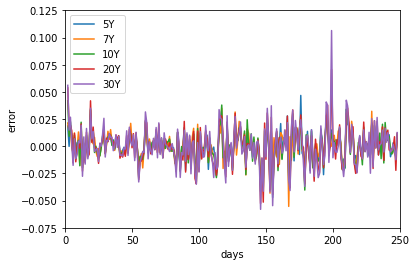

In [12]:
plt.clf() # clear figs
plt.cla() # clear axes

a = pd.read_csv("tnf.csv")
x = [a['x5'], a['x7'], a['x10'], a['x20'], a['x30']]

y = []
for each in fit:
    y.append(each.predict(dynamic=False)[2:249])

plt.xlim(0, 250)
plt.ylim(-0.075, 0.125)

plt.xlabel("days")
plt.ylabel("error")

avg_err = [0.0] * 5; c = 5
while c > 0:
    c -= 1
    avg_err[c-1] = (1 - y[c] / x[c])
    plt.plot(1 - y[c] / x[c])

handle = ["5Y", "7Y", "10Y", "20Y", "30Y"]
plt.legend(handle, loc = "upper left")

plt.show()

**Average Error Rates**

<p font-color:"navy">and here are the prediction error rates of the forecasts:</p>

<BarContainer object of 5 artists>

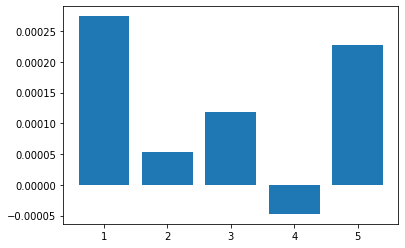

In [13]:
ϵ = []

for each in avg_err:
    ϵ.append(np.mean(each[2:249]))

plt.bar(x = [1, 2, 3, 4, 5], height = ϵ)

The $\text{ARIMA}$ models is now optimal.

I use

$$
    W_t = \mu + \overbrace{\phi_1 W_{t -1} + \phi_2 W_{t - 2} + \cdots + \phi_p W_{t - p}}^{\text{lagged W values}} + \epsilon_t - \underbrace{\theta_1 \epsilon_{t - 1} - \theta_2 \epsilon_{t - 2} - \cdots - \theta_q \epsilon_{t - q}}_{\text{lagged error terms}} \quad \forall \phi \in (-1, 1) \quad \forall \theta \in [-1, 1] \quad \backslash 0
$$

as my template.

It is good to be mindful of the fact that the coefficients of the lagged values and errors do change if using a simple differencing as opposed to making a log transformation before differencing each observation in the series. However, the variance of each model is less for the first-differences of log-transformations; hence, log-transformed first-differences are more precise for any predictive model that can be constructed using the $\text{AIC}$, due to the log-likelihood condition

## $\text{ARIMA}(p, 1, q)$ Model Results

Here, I am comparing the statespace $\text{SARIMAX}$ model from `statsmodels.tsa.statespace.sarimax` to the $\text{ARIMA}$ model from `statsmodels.tsa.arima.model`.

In [14]:
from statsmodels.tsa.arima.model import ARIMA

tnf = pd.read_csv("tnf.csv")
idx = [0, 1, 2, 3, 4]
key = ['x5', 'x7', 'x10', 'x20', 'x30']
order_list = [(1, 1, 1), (0, 1, 1), (0, 1, 1), (3, 1, 1), (2, 1, 3)]

mods = []
for i in idx:
    mods.append(ARIMA(endog=tnf[key[i]], order=order_list[i]))

fit = []
for mod in mods:
    fit.append(mod.fit())

for each in fit:
    print(each.summary())

                               SARIMAX Results                                
Dep. Variable:                     x5   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 534.650
Date:                Tue, 18 Jan 2022   AIC                          -1063.299
Time:                        19:48:11   BIC                          -1052.747
Sample:                             0   HQIC                         -1059.052
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4823      0.434      1.110      0.267      -0.369       1.334
ma.L1         -0.3777      0.454     -0.831      0.406      -1.269       0.513
sigma2         0.0008    4.4e-05     18.141      0.0

$$
    \begin{matrix}
        \text{T} & (p, d, q) & \text{Fitted Model} & \sigma^2 \\
        05 & (1, 1, 1) & 0.4823w_{t - 1} - 0.3777\epsilon_{t - 1} & 0.0008 \\
        07 & (0, 1, 1) & 0.0457\epsilon_{t - 1} & 0.0007 \\
        10 & (0, 1, 1) & 0.0464\epsilon_{t - 1} & 0.0006 \\
        20 & (3, 1, 1) & \ \ 0.0475w_{t - 1} + 0.1282w_{t - 2} - 0.1576w_{t - 3} + 0.0530\epsilon_{t - 1} \ \ \quad\quad\quad\quad & 0.0005 \\
        30 & (2, 1, 3) & -0.0019w_{t - 1} + 0.5278w_{t - 2} + 0.1446\epsilon_{t - 1} - 0.4749\epsilon_{t - 2} - 0.2370\epsilon_{t - 3} & 0.0005
    \end{matrix}
$$

**Error Series**

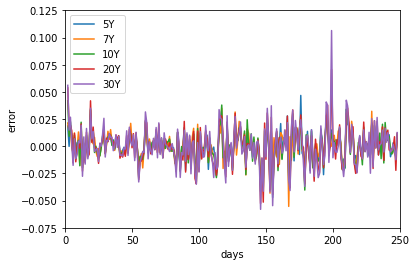

In [15]:
plt.clf() # clear figs
plt.cla() # clear axes

a = pd.read_csv("tnf.csv")
x = [a['x5'], a['x7'], a['x10'], a['x20'], a['x30']]

y = []
for each in fit:
    y.append(each.predict(dynamic=False)[2:249])

plt.xlim(0, 250)
plt.ylim(-0.075, 0.125)

plt.xlabel("days")
plt.ylabel("error")

avg_err = [0.0] * 5; c = 5
while c > 0:
    c -= 1
    avg_err[c-1] = (1 - y[c] / x[c])
    plt.plot(1 - y[c] / x[c])

handle = ["5Y", "7Y", "10Y", "20Y", "30Y"]
plt.legend(handle, loc = "upper left")

plt.show()

**Average Error Rates**

<BarContainer object of 5 artists>

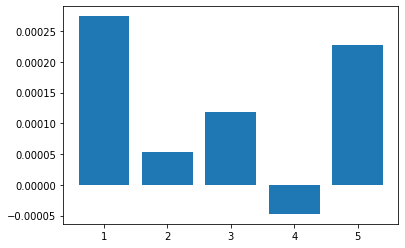

In [16]:
ϵ = []

for each in avg_err:
    ϵ.append(np.mean(each[2:249]))

plt.bar(x = [1, 2, 3, 4, 5], height = ϵ)

The models generated from the `statsmodels.tsa.statespace.sarimax` and `statsmodels.tsa.arima.model` packages are equal!

## Saving Python Models for Later

In [17]:
import pickle

pickle.dump(fit, open("C:\\Users\\Owner\\Documents\\Economics\\Financial Economics\\Research\\Securities Experiment\\mod", "wb"))

# Using Ljung-Box Statistics to Test for Residuals Without Autocorrelation

## A Foreword

Beforing starting this section, I pause and ask myself, "What are the residuals?". I remember when I took statistics that there was a residual sum of squares, which looked a little like this

$
    SS_{\text{res}} = SS_{\text{tot}} - SS_{\text{exp}}
$

In [18]:
Y = dict(
    Y05 = 0,
    Y07 = 1,
    Y10 = 2,
    Y20 = 3,
    Y30 = 4
)

However, since I am working with one regressor (i.e., an auto-regressive process), more pressure is placed on *maximizing* the explained sum of squares and *minimizing* the residuals (for the auto-regressive process), Knowing what each lagged error is going to be, with 95% confidence, is very helpful.

For $T \in \{5, 7. 10, 20, 30\}$, I found $\text{ARIMA}$ models with $\sigma^2 \in \{0.0008, 0.0007, 0.0006, 0.0005, 0.0005\}$ for estimation errors $\epsilon$. The goal of this section is to study the residuals, which the ideal case would present a white noise with no autocorrelation. In `Treas TS Analysis II`, I will take this analysis further by considering various volatility models, such as `T-GARCH`, which will give more insights into the resudual variation.

For a Ljung Box test $\mathcal{L}$

$$H^\mathcal{L} = \begin{cases}
    H_0: \text{there is no autocorrelation} & \text{if}\ p \lt 0.05 \\
    H_a: \text{there is autocorrelation} & \text{if}\ p \geq 0.05
\end{cases}$$

where $H_0$ would indicate uncorrelated residuals and $H_a$, correlated residuals, with p-value $p$ denoting the confidence level of the right tail test, therefore, the residual series comes from and independent, and identically-distributed (iid) randome variable.

**Ljung-Box test for 05Y Note CMT**

In [19]:
ljung_box, p_value = acorr_ljungbox(fit[Y["Y05"]].resid)
print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: [9.96210355e-04 8.36458716e-01 8.83908243e-01 1.10488535e+00
 1.11158248e+00 1.23732832e+00 1.24459028e+00 1.29581811e+00
 1.33014444e+00 1.35168132e+00]
p-value: [0.97482071 0.65821125 0.82930928 0.89349632 0.95307334 0.97500082
 0.98986372 0.99560195 0.99822166 0.99932781]


**Ljung-Box test for 07Y Note CMT**

In [20]:
ljung_box, p_value = acorr_ljungbox(fit[Y["Y07"]].resid)
print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: [0.03028119 0.86337359 0.9297575  1.02062011 1.05605575 1.18805496
 1.22860573 1.31666513 1.31673714 1.32406557]
p-value: [0.86185373 0.64941274 0.81824134 0.90665335 0.95791897 0.9774706
 0.99025327 0.99535006 0.99829175 0.99938683]


**Ljung-Box test for 10Y Bond CMT**

In [21]:
ljung_box, p_value = acorr_ljungbox(fit[Y["Y10"]].resid)
print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: [0.01435074 0.5657146  0.57426444 0.69931052 0.70266002 0.73770836
 0.76570302 0.81196601 0.81196834 0.83077079]
p-value: [0.90464589 0.75362732 0.90229783 0.95141392 0.98282237 0.99364084
 0.99777842 0.99918013 0.99976231 0.99992697]


**Ljung-Box test for 20Y Bond CMT**

In [22]:
ljung_box, p_value = acorr_ljungbox(fit[Y["Y20"]].resid)
print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: [0.01157169 0.11760491 0.15492354 0.24586108 0.24899756 0.26935311
 0.3146409  0.33800373 0.34505391 0.42740739]
p-value: [0.91433539 0.94289302 0.98451541 0.99303565 0.99849385 0.99963187
 0.99988247 0.9999703  0.99999389 0.99999689]


**Ljung-Box test for 30Y Bond CMT**

In [23]:
ljung_box, p_value = acorr_ljungbox(fit[Y["Y30"]].resid)
print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: [0.00524613 0.09125398 0.09126503 0.18369912 0.20483157 0.23297169
 0.26124065 0.26235266 0.26332836 0.27184103]
p-value: [0.94225955 0.95539827 0.99286464 0.99603144 0.99906098 0.99975854
 0.99993743 0.99998889 0.99999813 0.99999965]


## Plotting ACF and PACF of the Residuals to Support Ljung Box Test Results

PACF and ACF plots can be constructed to visually support the Ljung Box tests above.

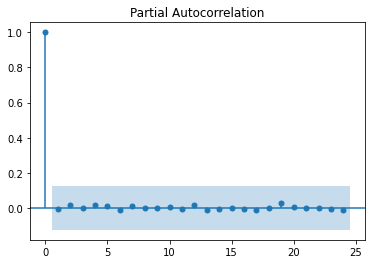

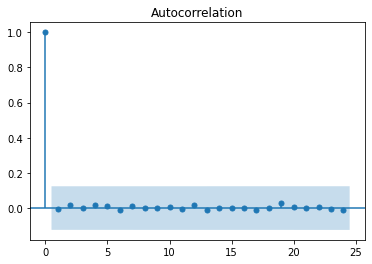

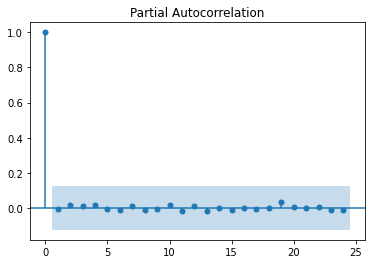

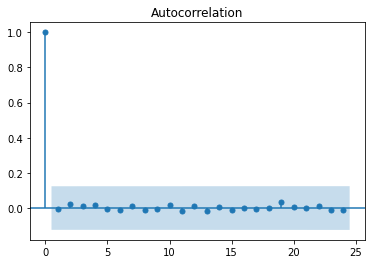

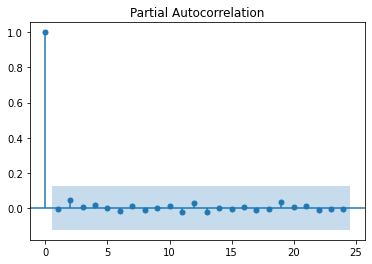

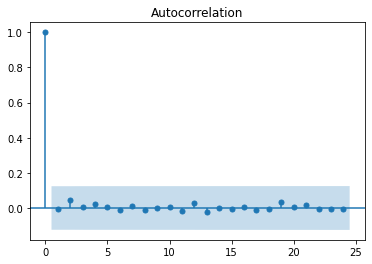

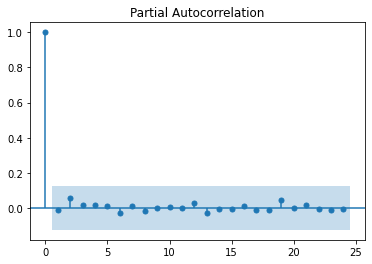

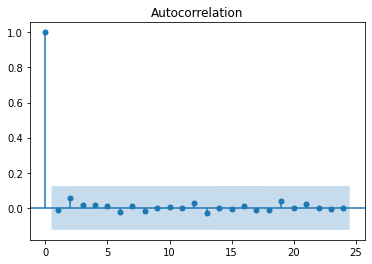

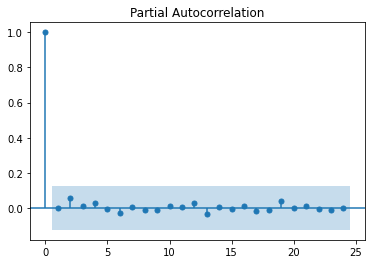

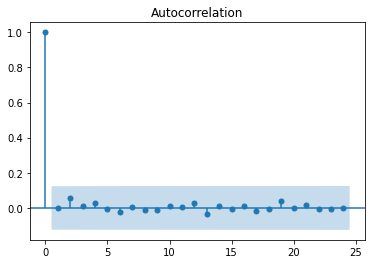

In [24]:
I = 5
while(I > 0):
    I = I - 1
    plot_pacf(fit[I].resid)
    plot_acf(fit[I].resid)

No significant support for the alternative hypothesis exists for neither the PACF, nor the ACF plots.  which means that the residuals are independent, each draw from an iid variable with $\epsilon \sim N(\mu, \sigma^2)$.

I also need to stress test the models to see if they break, and when they break, where do they break and why do they break? The **Markov Chain Monte Carlo** test is a test of durability$^?$. How would the model react if there were, say, a Poisson Arrival? How would the residual variation change?

It is also worthwhile exploring stochastic processes that are **heteroscedastic**, such as those that fall in the family of **General Autoregressive Conditional Heteroscedasticity** models (the **Extended GARCH** model, the **TGARCH** model, the **CHARMA** model, &c). A **Vector Autoregressive Fractional Integrated Moving Average (VARFIMA)** model could also be tried later on, and other models within the VARFIMA family that go beyond a simple ARIMA model. I may conclude with **Fourier Analysis** and **Spectral Analysis** representations of the financial time series.

## Summary and Next Steps

In this notebook, I learned that statespace models do work better than visualisation. Visualisation is still very powerful for collecting an overall, holistic view of the data, analyzing trends, performing cummulative sums and other summary statistics, such as boxplots for finding outliers in the financial data, knowing what the mean and kurtosis are, and finally, a visual summary can allow the data to speak for itself when it comes to densities, distributions and something not covered here: volatility surfaces.

In the next notebook, I will be touching on each of the following:

1. Time-Series Forecasting
2. Cross-Validation and Testing on New Data
3. Vector Autoregressive Fractional Integrated Moving Average
4. Markov Chain Monte Carlo
5. Heteroscedastic Models
6. Fourier Analysis and Spectral Analysis